# HTW E1

Thomas Gorman

In [ ]:
pacman::p_load(dplyr,purrr,tidyr,tibble,ggplot2,
  brms,tidybayes, rstanarm,emmeans,broom,bayestestR,
  stringr, here,conflicted, patchwork, knitr,kableExtra)
#options(brms.backend="cmdstanr",mc.cores=4)
walk(c("brms","dplyr","bayestestR"), conflict_prefer_all, quiet = TRUE)
walk(c("Display_Functions","org_functions"), ~ source(here::here(paste0("Functions/", .x, ".R"))))
e1 <- readRDS(here("data/e1_08-21-23.rds")) 
e1Sbjs <- e1 |> group_by(id,condit) |> summarise(n=n())
testE1 <- e1 |> filter(expMode2 == "Test")
nbins=5
trainE1 <-  e1 |> filter(expMode2=="Train") |> group_by(id,condit, vb) |> 
    mutate(Trial_Bin = cut( gt.train, breaks = seq(1, max(gt.train),length.out=nbins+1),include.lowest = TRUE, labels=FALSE)) 
trainE1_max <- trainE1 |> filter(Trial_Bin == nbins, bandInt==800)
trainE1_avg <- trainE1_max |> group_by(id,condit) |> summarise(avg = mean(dist))

### Analyses Strategy

All data processing and statistical analyses were performed in R version
4.32 Team (2020). To assess differences between groups, we used Bayesian
Mixed Effects Regression. Model fitting was performed with the brms
package in R Bürkner (2017), and descriptive stats and tables were
extracted with the BayestestR package Makowski et al. (2019). Mixed
effects regression enables us to take advantage of partial pooling,
simultaneously estimating parameters at the individual and group level.
Our use of Bayesian, rather than frequentist methods allows us to
directly quantify the uncertainty in our parameter estimates, as well as
avoiding convergence issues common to the frequentist analogues of our
mixed models.

Each model was set to run with 4 chains, 5000 iterations per chain, with
the first 2500 discarded as warmup chains. Rhat values were within an
acceptable range, with values \<=1.02 (see appendix for diagnostic
plots). We used uninformative priors for the fixed effects of the model
(condition and velocity band), and weakly informative Student T
distributions for for the random effects. For each model, we report 1)
the mean values of the posterior distribution for the parameters of
interest, 2) the lower and upper credible intervals (CrI), and the
probability of direction value (pd).

| Group Comparison         | Code                                                  | Data                 |
|-----------------|----------------------------------------|---------------|
| End of Training Accuracy | `brm(dist ~ condit)`                                  | Final Training Block |
| Test Accuracy            | `brm(dist ~ condit * bandType + (1|id) + (1|bandInt)` | All Testing trials   |
| Band Discrimination      | `brm(vx ~ condit * band +(1 + bandInt|id)`            | All Testing Trials   |

In each experiment we compare varied and constant performance on 1)
accuracy in the final training block; 2) testing accuracy as a function
of band type (trained vs. extrapolation); 3) degree of discrimination
between all six testing bands. We quantified accuracy as the absolute
deviation between the response velocity and the nearest boundary of the
target band. Thus, when the target band was velocity 600-800, throws of
400, 650, and 900 would result in deviation values of 200, 0, and 100,
respectively. The degree of discrimination between bands was index by
fitting a linear model predicting the response velocity as a function of
the target velocity. Participants who reliably discriminated between
velocity bands tended to haves slope values ~1, while participants who
made throws irrespective of the current target band would have slopes
~0.

### Results

In [ ]:
p1 <- trainE1 |> ggplot(aes(x = Trial_Bin, y = dist, color = condit)) +
    stat_summary(geom = "line", fun = mean) +
    stat_summary(geom = "errorbar", fun.data = mean_se, width = .4, alpha = .7) +
    facet_wrap(~vb)+
    scale_x_continuous(breaks = seq(1, nbins + 1)) +
    theme(legend.title=element_blank()) + 
    labs(y = "Deviation", x="Training Block") 
#ggsave(here("Assets/figs/e1_train_deviation.png"), p1, width = 8, height = 4,bg="white")

<figure id="fig-e1-train-dev">
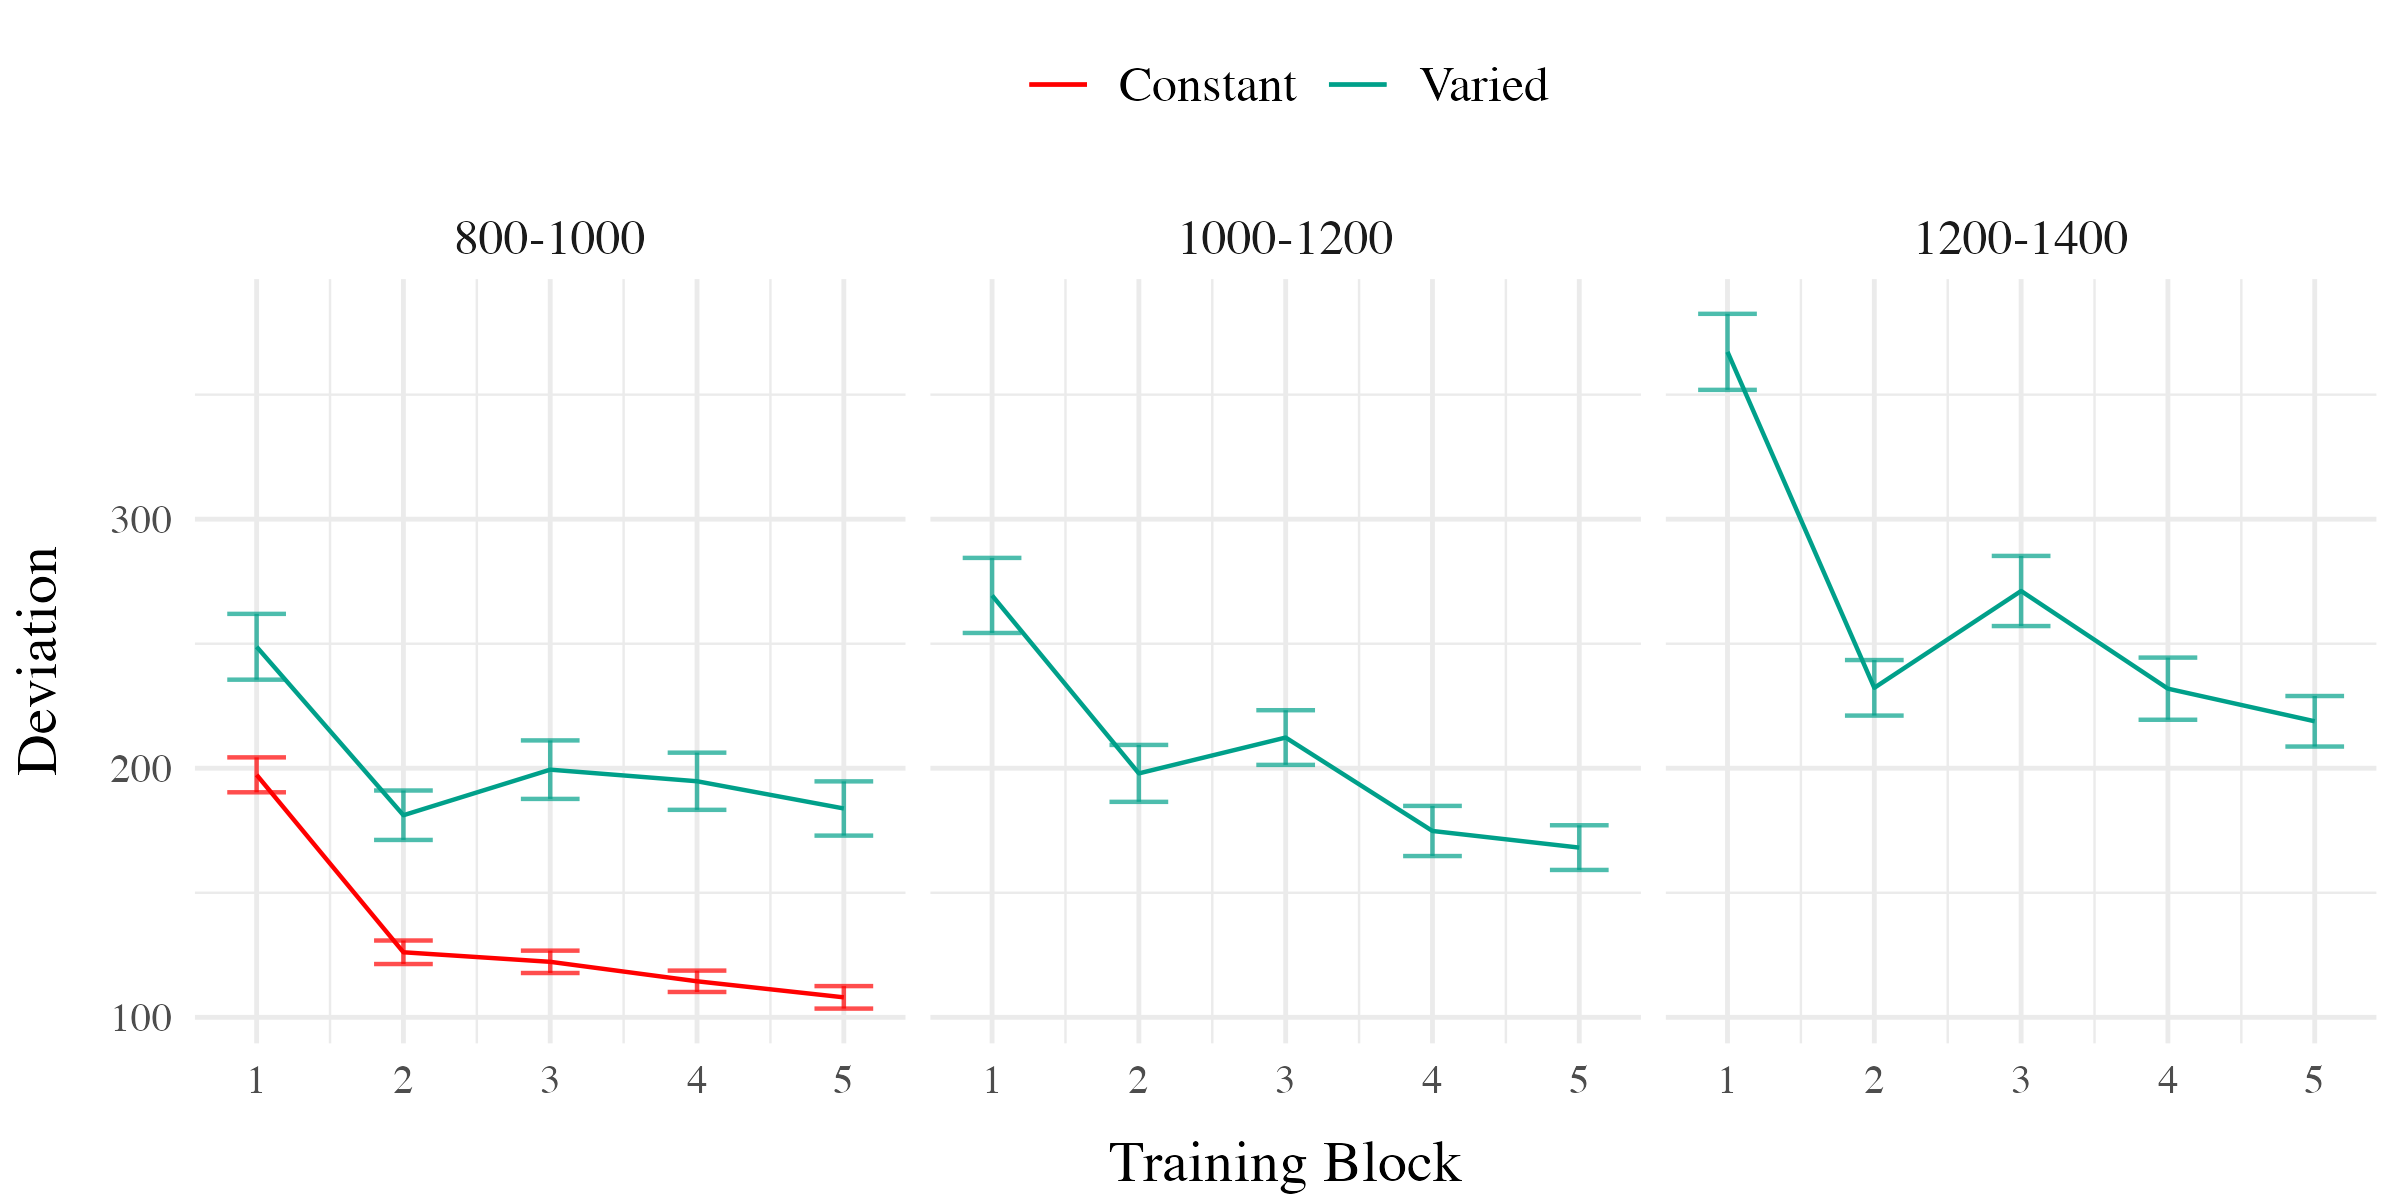
<figcaption>Figure 1: E1. Deviations from target band during
training</figcaption>
</figure>

In [ ]:
##| label: tbl-e1-train-dist
##| tbl-cap: "Experiment 1 - Learning curves. "
##| output: asis

bmm_e1_train<- trainE1_max %>% 
  brm(dist ~ condit, 
      file=here("data/model_cache/e1_train_deviation"),
      data = .,
      iter = 2000,
      chains = 4,
      control = list(adapt_delta = .94, max_treedepth = 13))
mtr1 <- as.data.frame(describe_posterior(bmm_e1_train, centrality = "Mean"))[, c(1,2,4,5,6)]
colnames(mtr1) <- c("Term", "Estimate","95% CrI Lower", "95% CrI Upper", "pd")

# mtr1 |> mutate(across(where(is.numeric), \(x) round(x, 2))) |>
#   tibble::remove_rownames() |> 
#   mutate(Term = stringr::str_remove(Term, "b_")) |>
#    kable(booktabs = TRUE)

cdtr1 <- get_coef_details(bmm_e1_train, "conditVaried")

| Term         | Estimate | 95% CrI Lower | 95% CrI Upper |  pd |
|:-------------|---------:|--------------:|--------------:|----:|
| Intercept    |   106.34 |         95.46 |        117.25 |   1 |
| conditVaried |    79.64 |         57.92 |        101.63 |   1 |

Table 1: **Experiment 1 - End of training performance**. The Intercept
represents the average of the baseline (constant condition), and the
conditVaried coefficient reflects the difference between the constant
and varied groups. A larger positive estimates indicates a greater
deviation (lower accuracy) for the varied group.

  

*Training*. <a href="#fig-e1-train-dev" class="quarto-xref">Figure 1</a>
displays the average deviations across training blocks (recall that the
varied group trains from 3 bands and the constant group from 1). We
compared the training conditions from the final training block, on the
position for which both groups trained (band 800-1000). Full model
results are shown in
<a href="#tbl-e1-train-dist" class="quarto-xref">Table 1</a>. The varied
group had a significantly greater deviation than the constant group.
($B$ = 79.64, 95% CrI \[57.92, 101.63\]; pd = 100%).

In [ ]:
##| label: tbl-e1-bmm-dist
##| tbl-cap: "E1. Training vs. Extrapolation"
#| 

modelFile <- paste0(here::here("data/model_cache/"), "e1_dist_Cond_Type_RF_2")
bmtd <- brm(dist ~ condit * bandType + (1|bandInt) + (1|id), 
    data=testE1, file=modelFile,
    iter=5000,chains=4, control = list(adapt_delta = .94, max_treedepth = 13))
                        
mted1 <- as.data.frame(describe_posterior(bmtd, centrality = "Mean"))[, c(1,2,4,5,6)]
colnames(mted1) <- c("Term", "Estimate","95% CrI Lower", "95% CrI Upper", "pd")


# r_bandInt_params <- get_variables(bmtd)[grepl("r_bandInt", get_variables(bmtd))]
# posterior_summary(bmtd,variable=r_bandInt_params)
# 
# r_bandInt_params <- get_variables(bmtd)[grepl("r_id:bandInt", get_variables(bmtd))]
# posterior_summary(bmtd,variable=r_bandInt_params)

# mted1 |> mutate(across(where(is.numeric), \(x) round(x, 2))) |>
#   tibble::remove_rownames() |> 
#   mutate(Term = stringr::str_remove(Term, "b_")) |> kable(booktabs = TRUE)


cdted1 <- get_coef_details(bmtd, "conditVaried")
cdted2 <-get_coef_details(bmtd, "bandTypeExtrapolation")
cdted3 <-get_coef_details(bmtd, "conditVaried:bandTypeExtrapolation")

| Term                               | Estimate | 95% CrI Lower | 95% CrI Upper |  pd |
|:-----------------------|-----------:|-----------:|-----------:|-----------:|
| Intercept                          |   152.55 |         70.63 |        229.85 | 1.0 |
| conditVaried                       |    39.00 |        -21.10 |        100.81 | 0.9 |
| bandTypeExtrapolation              |    71.51 |         33.24 |        109.60 | 1.0 |
| conditVaried:bandTypeExtrapolation |    66.46 |         32.76 |         99.36 | 1.0 |

Table 2: **Experiment 1 testing accuracy**. Main effects of condition
and band type (training vs. extrapolation), and the interaction between
the two factors.

*Testing.* To compare conditions in the testing stage, we first fit a
model predicting deviation from the target band as a function of
training condition and band type, with random intercepts for
participants and bands. The model is shown in
<a href="#tbl-e1-bmm-dist" class="quarto-xref">Table 2</a>. The effect
of training condition was not reliably different from 0 ($B$ = 39, 95%
CrI \[-21.1, 100.81\]; pd = 89.93%). The extrapolation testing items had
a significantly greater deviation than the interpolation band (β =
71.51, 95% CrI \[33.24, 109.6\]; pd = 99.99%). The interaction between
training condition and band type was significant ($B$ = 66.46, 95% CrI
\[32.76, 99.36\]; pd = 99.99%), with the varied group showing a greater
deviation than the constant group in the extrapolation bands. See
<a href="#fig-e1-test-dev" class="quarto-xref">Figure 2</a>.

In [ ]:
##| eval: FALSE
pe1td <- testE1 |>  ggplot(aes(x = vb, y = dist,fill=condit)) +
    stat_summary(geom = "bar", position=position_dodge(), fun = mean) +
    stat_summary(geom = "errorbar", position=position_dodge(.9), fun.data = mean_se, width = .4, alpha = .7) + 
  theme(legend.title=element_blank(),axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
  labs(x="Band", y="Deviation From Target")

condEffects <- function(m,xvar){
  m |> ggplot(aes(x = {{xvar}}, y = .value, color = condit, fill = condit)) + 
  stat_dist_pointinterval() + 
  stat_halfeye(alpha=.1, height=.5) +
  theme(legend.title=element_blank(),axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) 
  
}

pe1ce <- bmtd |> emmeans( ~condit + bandType) |>
  gather_emmeans_draws() |>
 condEffects(bandType) + labs(y="Absolute Deviation From Band", x="Band Type")

p2 <- (pe1td + pe1ce) + plot_annotation(tag_levels= 'A')
#ggsave(here::here("Assets/figs", "e1_test-dev.png"), p2, width=8, height=4, bg="white")

<figure id="fig-e1-test-dev">
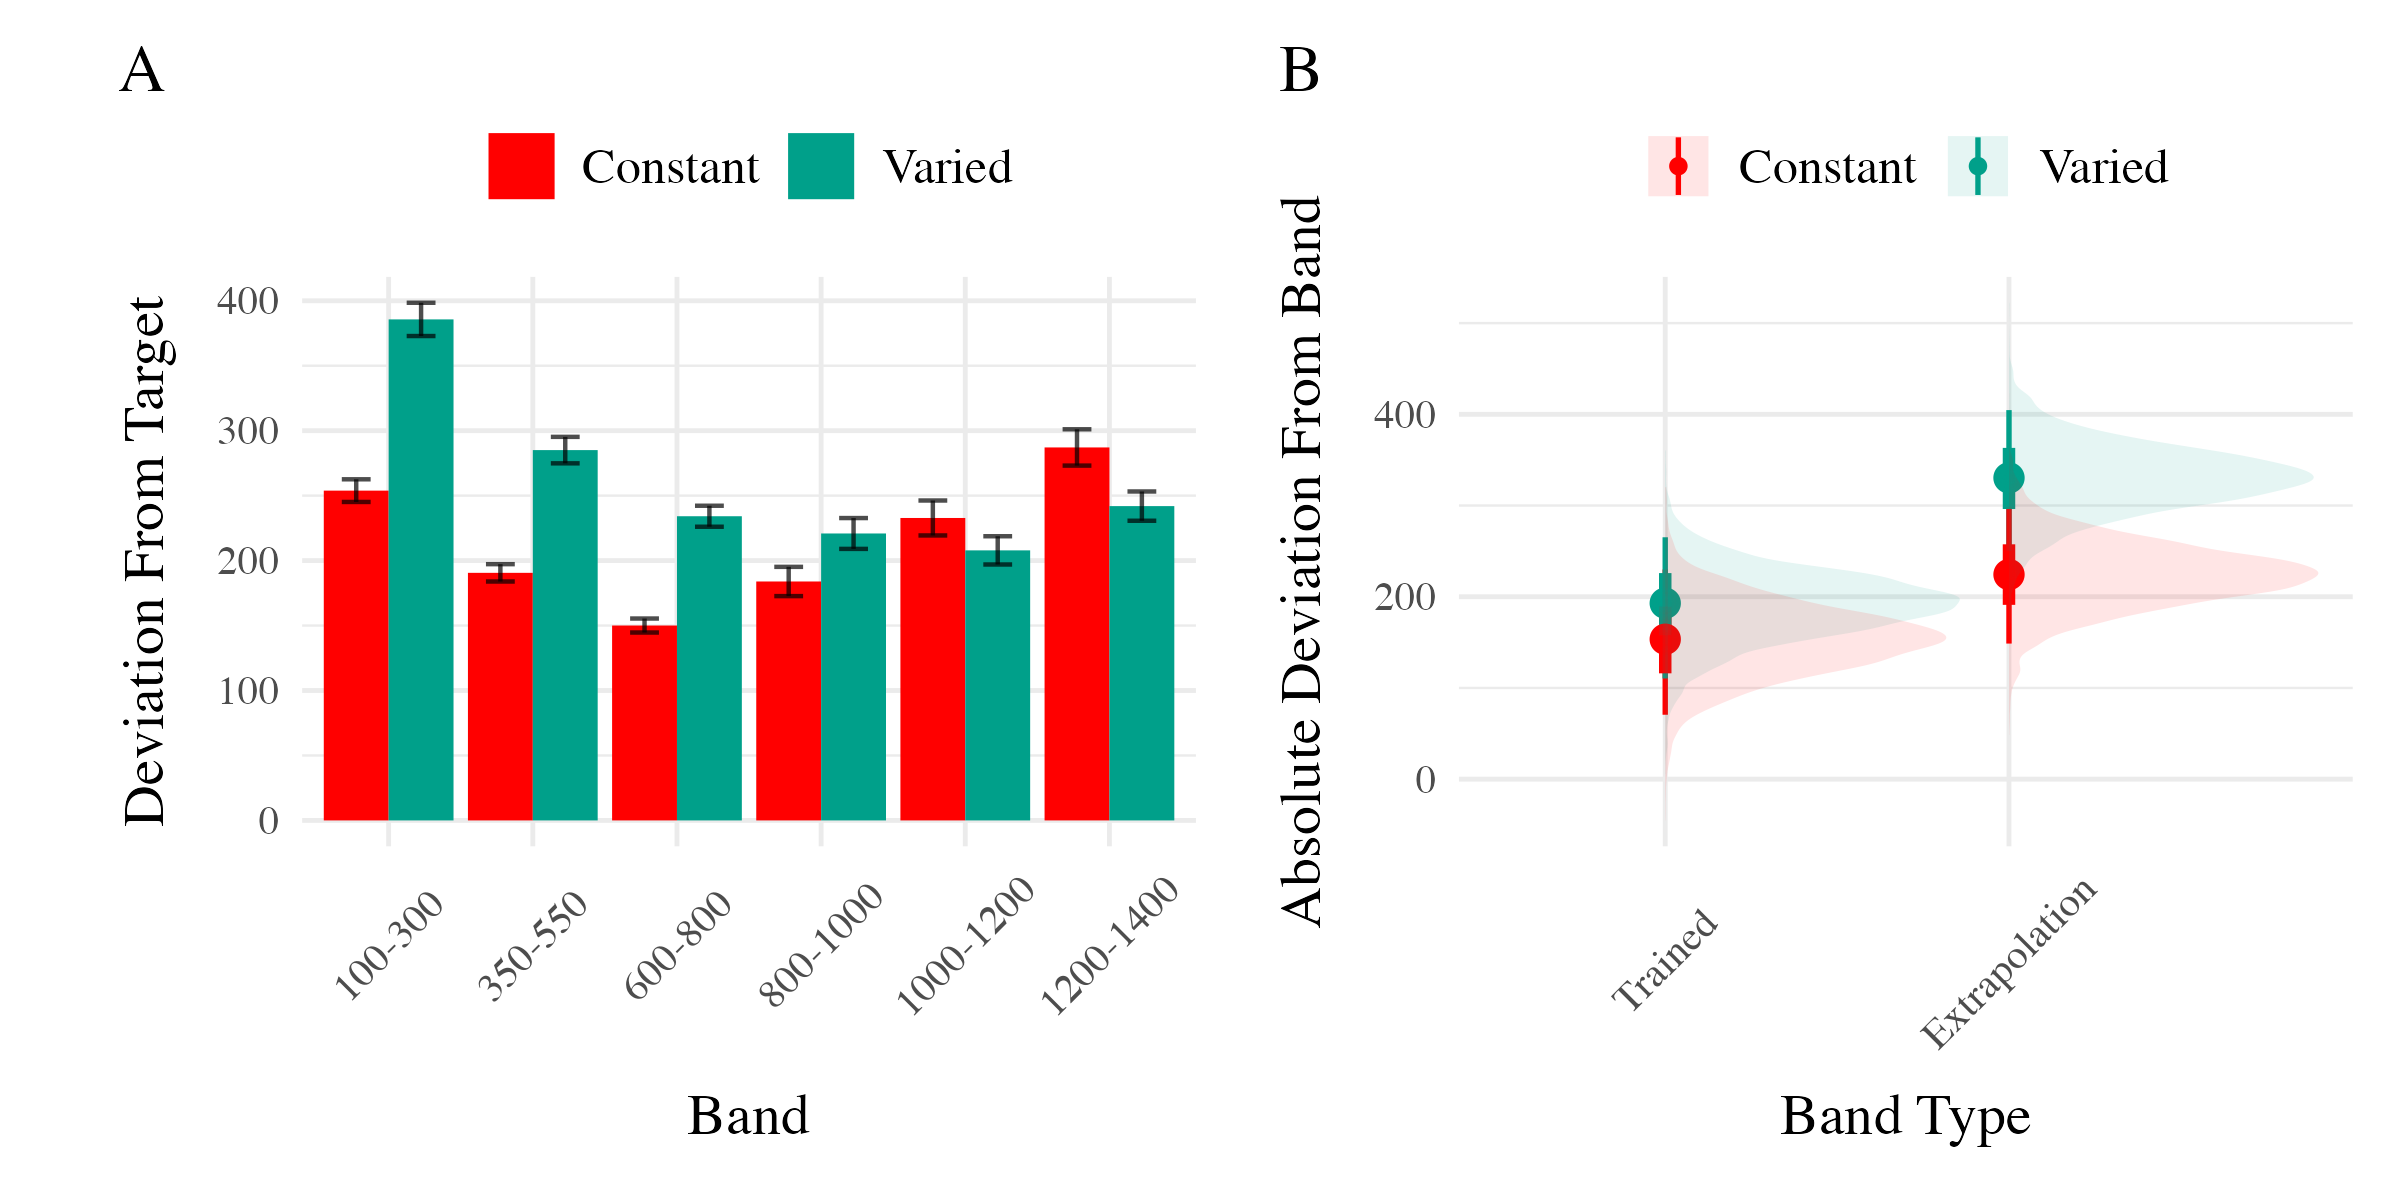
<figcaption>Figure 2: E1. A) Deviations from target band during testing
without feedback stage. B) Estimated marginal means for the interaction
between training condition and band type. Error bars represent 95%
confidence intervals.</figcaption>
</figure>

In [ ]:
##| label: tbl-e1-bmm-vx
##| tbl-cap: "Experiment 1. Bayesian Mixed Model Predicting Vx as a function of condition (Constant vs. Varied) and Velocity Band"
e1_vxBMM <- brm(vx ~ condit * bandInt + (1 + bandInt|id),
                        data=test,file=paste0(here::here("data/model_cache", "e1_testVxBand_RF_5k")),
                        iter=5000,chains=4,silent=0,
                        control=list(adapt_delta=0.94, max_treedepth=13))

#GetModelStats(e1_vxBMM) |> kable(booktabs = TRUE)

cd1 <- get_coef_details(e1_vxBMM, "conditVaried")
sc1 <- get_coef_details(e1_vxBMM, "bandInt")
intCoef1 <- get_coef_details(e1_vxBMM, "conditVaried:bandInt")

  

| Term         | Estimate | 95% CrI Lower | 95% CrI Upper |   pd |
|:-------------|---------:|--------------:|--------------:|-----:|
| Intercept    |   408.55 |        327.00 |        490.61 | 1.00 |
| conditVaried |   164.05 |         45.50 |        278.85 | 1.00 |
| Band         |     0.71 |          0.62 |          0.80 | 1.00 |
| condit\*Band |    -0.14 |         -0.26 |         -0.01 | 0.98 |

Table 3: Experiment 1. Bayesian Mixed Model Predicting Vx as a function
of condition (Constant vs. Varied) and Velocity Band

Finally, to assess the ability of both conditions to discriminate
between velocity bands, we fit a model predicting velocity as a function
of training condition and velocity band, with random intercepts and
random slopes for each participant. See
<a href="#tbl-e1-bmm-vx" class="quarto-xref">Table 3</a> for the full
model results. The estimated coefficient for training condition (β =
164.05, 95% CrI \[45.5, 278.85\]) suggests that the varied group tends
to produce harder throws than the constant group, but is not in and of
itself useful for assessing discrimination. Most relevant to the issue
of discrimination is the slope on Velocity Band (β = 0.71, 95% CrI
\[0.62, 0.8\]). Although the median slope does fall underneath the ideal
of value of 1, the fact that the 95% credible interval does not contain
0 provides strong evidence that participants exhibited some
discrimination between bands. The estimate for the interaction between
slope and condition (β = -0.14, 95% CrI \[-0.26, -0.01\]), suggests that
the discrimination was somewhat modulated by training condition, with
the varied participants showing less sensitivity between bands than the
constant condition. This difference is depicted visually in
<a href="#fig-e1-test-vx" class="quarto-xref">Figure 4</a>.

In [ ]:
##| eval: FALSE

pe1tv <- testE1 %>% group_by(id,vb,condit) |> plot_distByCondit()

pe1vce <- e1_vxBMM |> emmeans( ~condit + bandInt,re_formula=NA, 
                       at = list(bandInt = c(100, 350, 600, 800, 1000, 1200))) |>
  gather_emmeans_draws() |> 
  condEffects(bandInt) +
  stat_lineribbon(alpha = .25, size = 1, .width = c(.95)) +
  scale_x_continuous(breaks = c(100, 350, 600, 800, 1000, 1200), 
                     labels = levels(testE1$vb), 
                     limits = c(0, 1400)) + 
  scale_y_continuous(expand=expansion(add=100),breaks=round(seq(0,2000,by=200),2)) +
  theme(legend.title=element_blank()) + 
  labs(y="Velcoity", x="Band")

fe <- fixef(e1_vxBMM)[,1]
fixed_effect_bandInt <- fixef(e1_vxBMM)[,1]["bandInt"]
fixed_effect_interaction <- fixef(e1_vxBMM)[,1]["conditVaried:bandInt"]

re <- data.frame(ranef(e1_vxBMM, pars = "bandInt")$id[, ,'bandInt']) |> 
  rownames_to_column("id") |> 
  left_join(e1Sbjs,by="id") |>
  mutate(adjust= fixed_effect_bandInt + fixed_effect_interaction*(condit=="Varied"),slope = Estimate + adjust )


pid_den1 <- ggplot(re, aes(x = slope, fill = condit)) + 
  geom_density(alpha=.5) + 
  xlim(c(min(re$slope)-.3, max(re$slope)+.3))+
   theme(legend.title=element_blank()) + 
  labs(x="Slope Coefficient",y="Density")

pid_slopes1 <- re |>  mutate(id=reorder(id,slope)) |>
  ggplot(aes(y=id, x=slope,fill=condit,color=condit)) + 
    geom_pointrange(aes(xmin=Q2.5+adjust, xmax=Q97.5+adjust)) + 
     theme(legend.title=element_blank(), 
           axis.text.y = element_text(size=6) ) + 
    labs(x="Estimated Slope", y="Participant")  + 
    ggh4x::facet_wrap2(~condit,axes="all",scales="free_y")

p3 <- pe1tv / (pe1vce + pid_den1 + pid_slopes1) + plot_annotation(tag_levels= 'A')
#ggsave(here::here("Assets/figs", "e1_test-vx.png"), p3,width=9,height=11, bg="white",dpi=600)
p3



<figure id="fig-e1-test-vx">
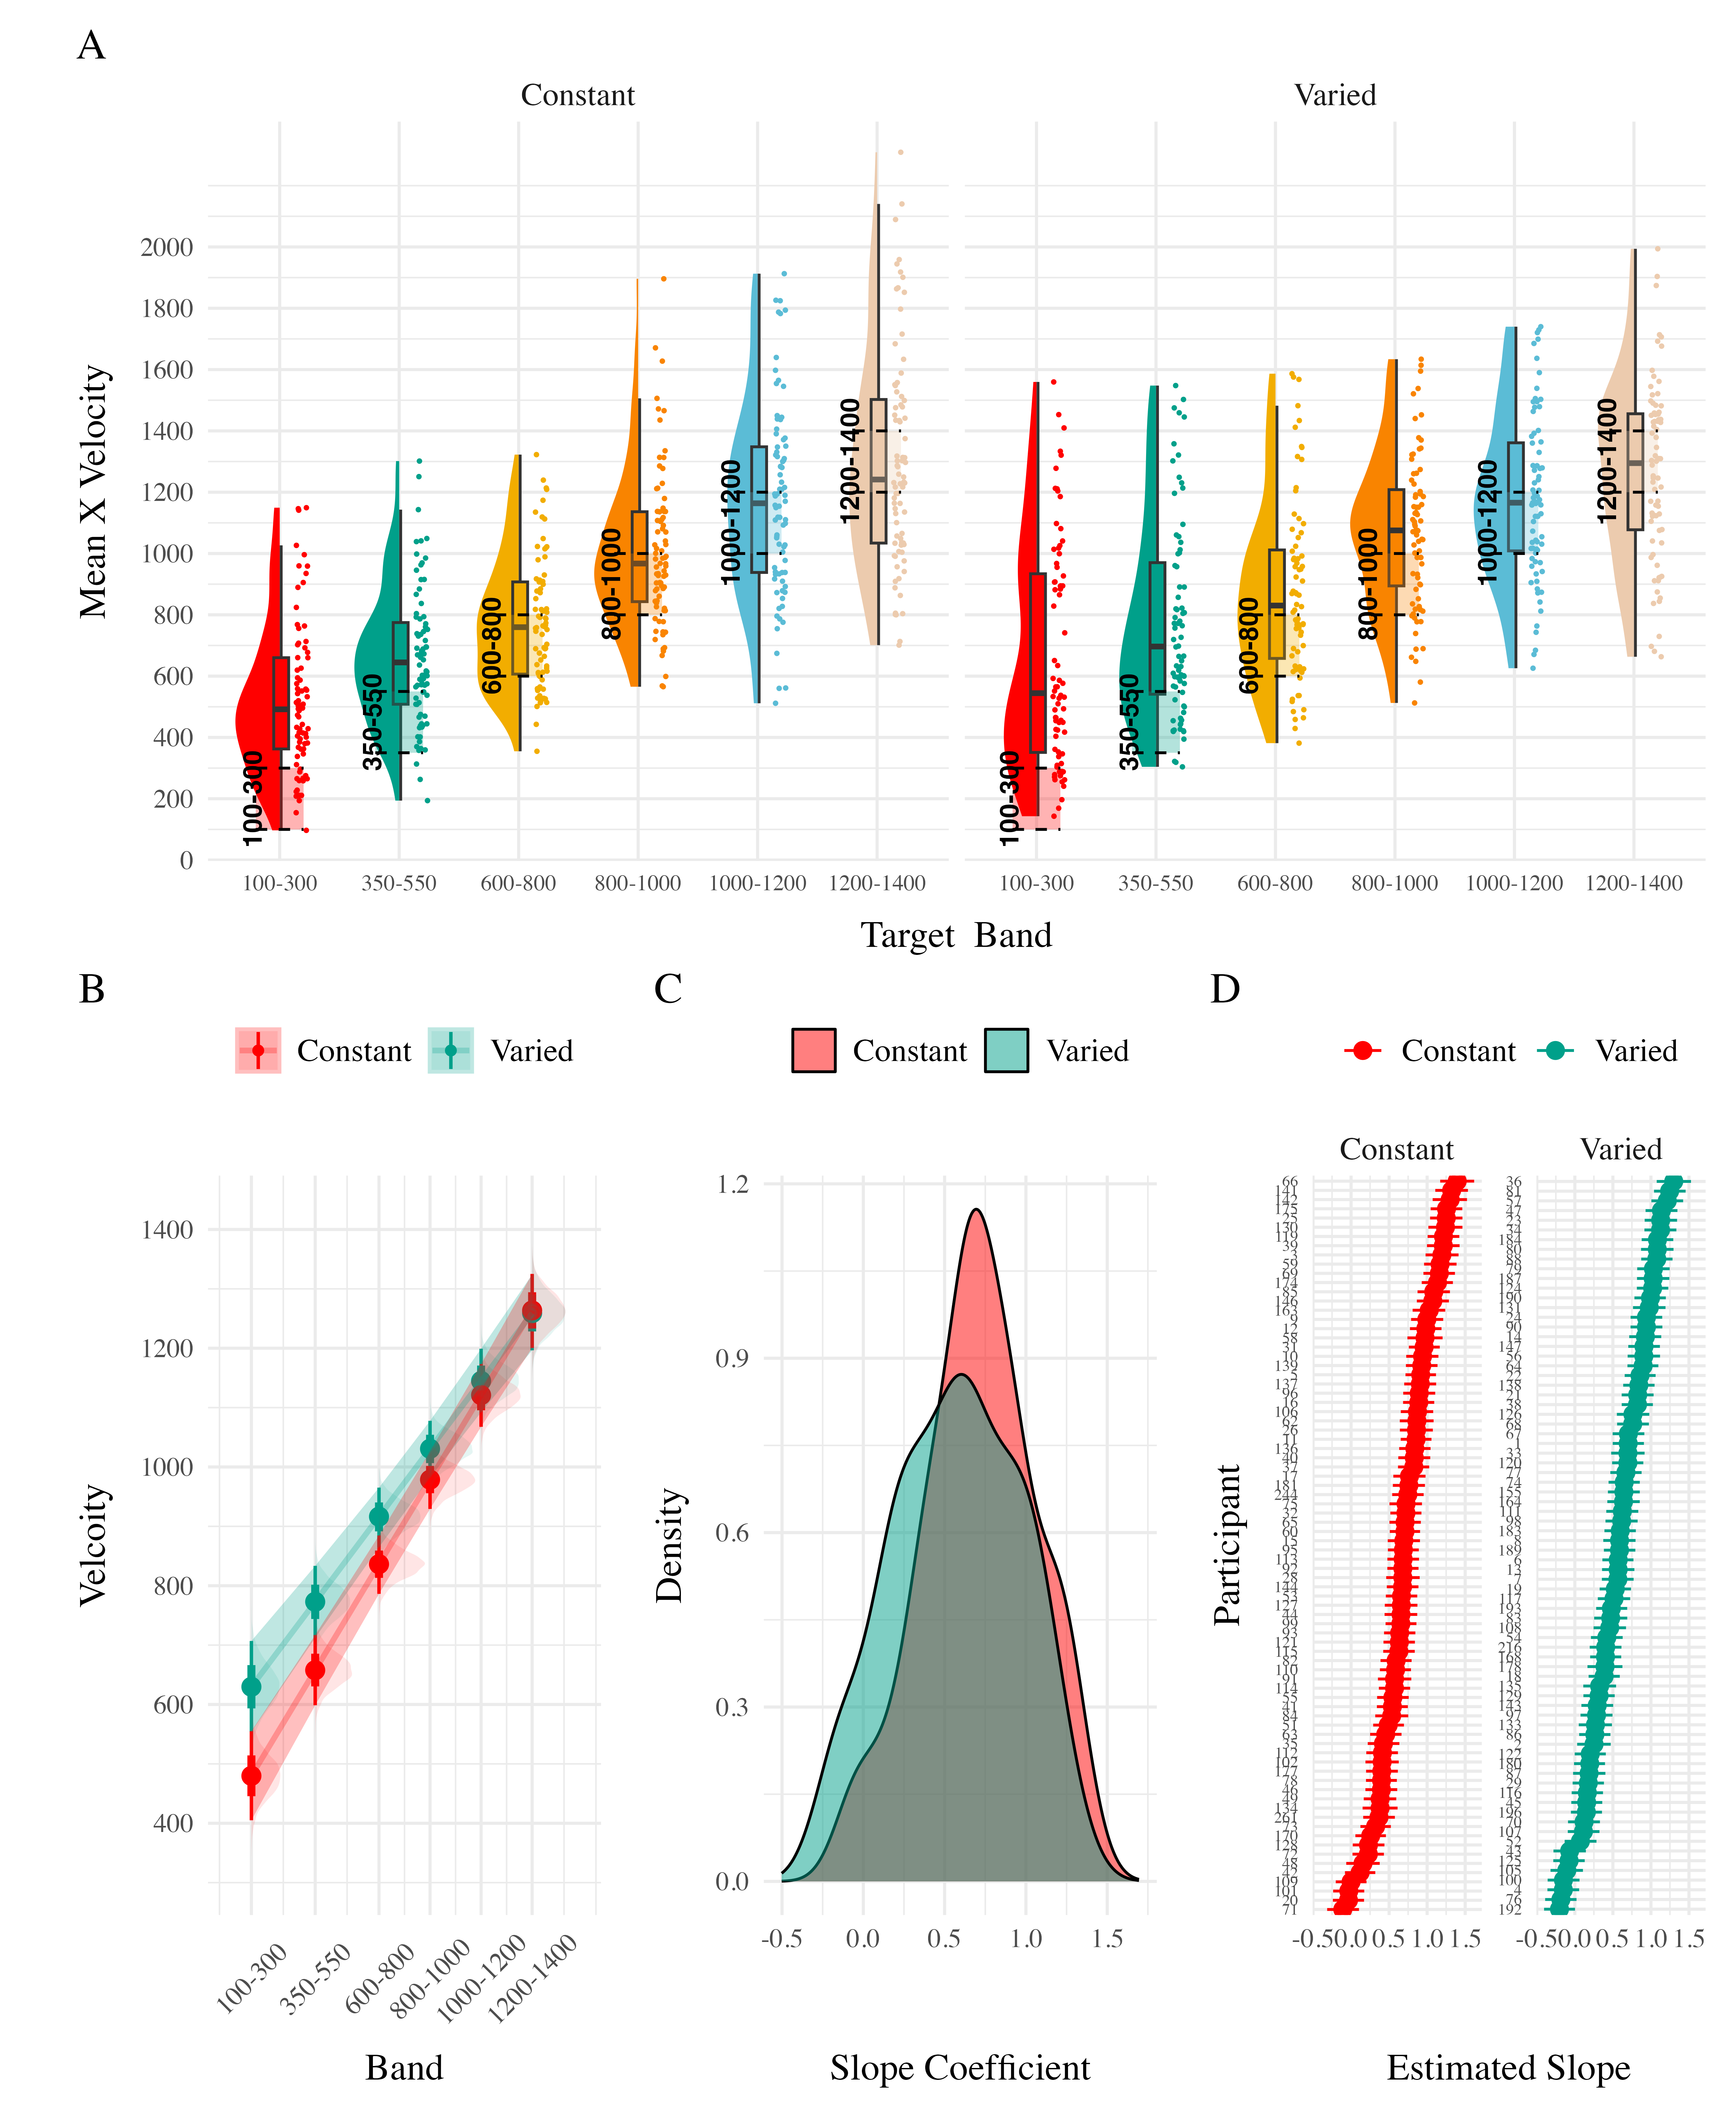
<figcaption>Figure 4: Experiment 1. Conditional effect of training
condition and Band. Ribbons indicate 95% HDI. The steepness of the lines
serves as an indicator of how well participants discriminated between
velocity bands.</figcaption>
</figure>



  
some text.  

## References

Bürkner, P.-C. (2017). Brms: An R Package for Bayesian Multilevel Models
Using Stan. *Journal of Statistical Software*, *80*, 1–28.
<https://doi.org/10.18637/jss.v080.i01>

Makowski, D., Ben-Shachar, M. S., & Lüdecke, D. (2019).
<span class="nocase">bayestestR</span>: Describing Effects and their
Uncertainty, Existence and Significance within the Bayesian Framework.
*Journal of Open Source Software*, *4*(40), 1541.
<https://doi.org/10.21105/joss.01541>

Team, R. C. (2020). *R: A Language and Environment for Statistical
Computing*. R: A Language and Environment for Statistical Computing.